In [1]:
import os
import math
import pathlib
import warnings
import mindspore
import numpy as np
from PIL import Image
from tqdm import tqdm
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore import Tensor
import mindspore.numpy as mnp
import mindspore.dataset as ds
from mindspore.ops import constexpr
import mindspore.ops.operations as P
import mindspore.dataset.vision as CV
import mindspore.dataset.transforms as T
from mindspore import context, Tensor, Model
import mindspore.common.initializer as weight_init
from typing import BinaryIO, Union, Optional, Tuple
from mindspore.ops._primitive_cache import _get_cache_prim
from mindspore.train.callback import CheckpointConfig, ModelCheckpoint
from mindspore.ops.operations.image_ops import ResizeBilinearV2, ResizeLinear1D
from mindspore.common.initializer import initializer, HeUniform, Uniform, Normal, _calculate_fan_in_and_fan_out

In [2]:
warnings.filterwarnings("ignore", category=Warning, module="mindspore.nn.layer.basic")
warnings.filterwarnings("ignore", category=Warning, module="mindspore.dataset.vision.c_transforms")
warnings.filterwarnings("ignore", category=Warning, module="mindspore.common.api")
warnings.filterwarnings("ignore", category=Warning, module="mindspore.dataset.core.validator_helpers")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="mindspore.*")

In [3]:
os.makedirs("images", exist_ok=True)


In [4]:
class Options:
    def __init__(self):
        self.n_epochs = 200
        self.batch_size = 64
        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.latent_dim = 100
        self.n_classes = 10
        self.img_size = 32
        self.channels = 1
        self.sample_interval = 400

# Create an instance of the Options class
opt = Options()

In [5]:
img_shape = (opt.channels, opt.img_size, opt.img_size)

latent_dim = opt.latent_dim
n_classes = opt.n_classes


In [6]:
context.set_context(mode=context.GRAPH_MODE, device_target="GPU", save_graphs=False)

In [7]:
class dropout(nn.Cell):
    def __init__(self, p=0.5):
        super().__init__()
        if p < 0 or p > 1:
            raise ValueError('error')
        self.p = 1 - p
        self.dropout2d = _Dropout2d(self.p)

    def construct(self, x):
        if not self.training:
            return x

        if self.p == 1:
            return x

        out, _ = self.dropout2d(x)
        return out

In [8]:

class Conv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, pad_mode='same', padding=0, dilation=1, group=1, has_bias=True):
        super(Conv2d, self).__init__(in_channels, out_channels, kernel_size, stride, pad_mode, padding, dilation, group, has_bias, weight_init=weight_init.initializer('HeUniform'), bias_init='zeros')


In [9]:
class Embedding(nn.Embedding):
    def __init__(self, vocab_size, embedding_size, use_one_hot=False, embedding_table='normal', dtype=mindspore.float32, padding_idx=None):
        if embedding_table == 'normal':
            embedding_table = Normal(1.0)
        super().__init__(vocab_size, embedding_size, use_one_hot, embedding_table, dtype, padding_idx)

In [10]:
class Dense(nn.Dense):
    def __init__(self, in_channels, out_channels, has_bias=True, activation=None):
        super().__init__(in_channels, out_channels, weight_init='normal', bias_init='zeros', has_bias=has_bias, activation=activation)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.weight.set_data(initializer(HeUniform(math.sqrt(5)), self.weight.shape))
        if self.has_bias:
            fan_in, _ = _calculate_fan_in_and_fan_out(self.weight.shape)
            bound = 1 / math.sqrt(fan_in)
            self.bias.set_data(initializer(Uniform(bound), [self.out_channels]))



def _check_scale_factor(shape, scale_factor):
    if isinstance(scale_factor, tuple) and len(scale_factor) != len(shape[2:]):
        raise ValueError(f"the number of 'scale_fator' must match to inputs.shape[2:], "
                         f"but get scale_factor={scale_factor}, inputs.shape[2:]={shape[2:]}")


def _interpolate_output_shape(shape, scales, sizes, mode):
    """calculate output shape"""
    if sizes is not None:
        if mode == "nearest":
            return sizes
        return Tensor(sizes)

    ret = ()        
    for i in range(len(shape[2:])):
        if isinstance(scales, float):
            out_i = int(scales * shape[i+2])
        else:
            out_i = int(scales[i] * shape[i+2])
        ret = ret + (out_i,)
    if mode == "nearest":
        return ret
    return Tensor(ret)



In [11]:
import mindspore.nn as nn
import mindspore.ops.operations as ops

class Upsample(nn.Cell):
    def __init__(self, size=None, scale_factor=None, mode='nearest', align_corners=False):
        super().__init__()
        self.size = size
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners = align_corners

    def construct(self, inputs):
        sizes = ops.ResizeBilinearV2(self.align_corners, not self.align_corners)(inputs.shape, self.scale_factor, self.size)
        interpolate = ops.ResizeNearestNeighbor if self.mode == 'nearest' else ops.ResizeBilinearV2(self.align_corners, not self.align_corners)
        return interpolate(inputs, sizes)
     

In [12]:
def MNIST_DATASET(data_path, mode, img_size, batch_size=32, shuffle=True, num_parallel_workers=1, drop_remainder=False):
   
    mnist_ds = ds.MnistDataset(data_path, mode)

    # define map operations
    img_transforms = [
        CV.Rescale(1.0 / 255.0, 0),
        CV.Resize(img_size, CV.Inter.BILINEAR),
        CV.Normalize([0.5], [0.5]),
        CV.HWC2CHW()
    ]
    label_transforms = [
        T.TypeCast(mindspore.int32)
    ]
    
    mnist_ds = mnist_ds.map(operations=img_transforms, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=label_transforms, input_columns="label", num_parallel_workers=num_parallel_workers)

    if shuffle:
        mnist_ds = mnist_ds.shuffle(buffer_size=1024)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=drop_remainder)

    return mnist_ds

In [13]:
def image(
    tensor,
    nrow: int = 8,
    padding: int = 2,
    normalize: bool = False,
    value_range: Optional[Tuple[int, int]] = None,
    scale_each: bool = False,
    pad_value: float = 0.0):

    if isinstance(tensor, list):
        tensor = mnp.stack(tensor, axis=0)

    if tensor.ndim == 2:  
        tensor = tensor.unsqueeze(0)
    if tensor.ndim == 3:  
        if tensor.shape[0] == 1:  
            tensor = mnp.concatenate((tensor, tensor, tensor), 0)
        tensor = tensor.expand_dims(0)

    if tensor.ndim == 4 and tensor.shape[1] == 1: 
        tensor = mnp.concatenate((tensor, tensor, tensor), 1)

    if normalize is True:
        tensor_list = []  
        if value_range is not None:
            assert isinstance(
                value_range, tuple
            ), "value_range has to be a tuples"

        def norm_ip(img, low, high):
            img = ops.clip_by_value(img, low, high)
            img = (img - low) / (max(high - low, 1e-5))
            return img

        def norm_range(t, value_range):
            if value_range is not None:
                return norm_ip(t, value_range[0], value_range[1])
            else:
                return norm_ip(t, float(t.min()), float(t.max()))

        if scale_each is True:
            for t in tensor:  
                tensor_list.append(norm_range(t, value_range))
        else:
            tensor_list = norm_range(tensor, value_range)

        if isinstance(tensor_list, mindspore.Tensor):
            tensor = tensor_list
        else:
            tensor = mnp.concatenate(tensor_list)

    assert isinstance(tensor, mindspore.Tensor)
    if tensor.shape[0] == 1:
        return tensor.squeeze(0)

    nmaps = tensor.shape[0]
    xmaps = min(nrow, nmaps)
    ymaps = int(math.ceil(float(nmaps) / xmaps))
    height, width = int(tensor.shape[2] + padding), int(tensor.shape[3] + padding)
    num_channels = tensor.shape[1]
    grid = mnp.full((num_channels, height * ymaps + padding, width * xmaps + padding), pad_value)
    k = 0
    for y in range(ymaps):
        for x in range(xmaps):
            if k >= nmaps:
                break
            grid[:, y * height + padding : (y + 1) * height, x * width + padding: (x + 1) * width] = tensor[k]
            k = k + 1
    return grid

In [14]:
def pic(tensor,
             fp: Union[str, pathlib.Path, BinaryIO],
             format=None,
             **kwargs):
    grid = image(tensor, **kwargs)
    ndarr = grid * 255 + 0.5
    ndarr = ops.clip_by_value(ndarr, 0, 255).transpose(1, 2, 0).astype(mindspore.uint8).asnumpy()
    im = Image.fromarray(ndarr)
    im.save(fp, format=format)

In [15]:
class Generator(nn.Cell):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = Embedding(opt.n_classes, opt.n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [Dense(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers
        
       # self.dropout = nn.Dropout(1 - 0.4)

        self.model = nn.SequentialCell(
            *block(opt.latent_dim + opt.n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            Dense(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def construct(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = ops.concat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.shape[0], *img_shape)
        return img

In [16]:
class Discriminator(nn.Cell):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = Embedding(opt.n_classes, opt.n_classes)

        self.model = nn.SequentialCell(
            Dense(opt.n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2),
            Dense(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Dense(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            Dense(512, 1),
        )

    def construct(self, img, labels):
        d_in = ops.concat((img.view(img.shape[0], -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [17]:
adversarial_loss = nn.MSELoss()

In [18]:
generator = Generator()
discriminator = Discriminator()

generator.update_parameters_name('generator')
discriminator.update_parameters_name('discriminator')
generator.set_train()
discriminator.set_train()

[WARNING] ME(9306:139835891393344,MainProcess):2023-08-08-21:20:53.238.004 [mindspore/nn/layer/basic.py:173] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(9306:139835891393344,MainProcess):2023-08-08-21:20:53.243.111 [mindspore/nn/layer/basic.py:173] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(9306:139835891393344,MainProcess):2023-08-08-21:20:53.253.703 [mindspore/nn/layer/basic.py:199] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(9306:139835891393344,MainProcess):2023-08-08-21:20:53.255.278 [mindspore/nn/layer/basic.py:199] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.


Discriminator<
  (label_embedding): Embedding<vocab_size=10, embedding_size=10, use_one_hot=False, embedding_table=Parameter (name=discriminatorlabel_embedding.embedding_table, shape=(10, 10), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
  (model): SequentialCell<
    (0): Dense<input_channels=1034, output_channels=512, has_bias=True>
    (1): LeakyReLU<>
    (2): Dense<input_channels=512, output_channels=512, has_bias=True>
    (3): Dropout<keep_prob=0.4>
    (4): LeakyReLU<>
    (5): Dense<input_channels=512, output_channels=512, has_bias=True>
    (6): Dropout<keep_prob=0.4>
    (7): LeakyReLU<>
    (8): Dense<input_channels=512, output_channels=1, has_bias=True>
    >
  >

In [19]:
# Optimizers
optimizer_G = nn.Adam(generator.trainable_params(), learning_rate=opt.lr, beta1=opt.b1, beta2=opt.b2)
optimizer_D = nn.Adam(discriminator.trainable_params(), learning_rate=opt.lr, beta1=opt.b1, beta2=opt.b2)
optimizer_G.update_parameters_name('optim_g')
optimizer_D.update_parameters_name('optim_d')

In [20]:
def sample_image(n_row, batches_done):
    z = mnp.randn((n_row ** 2, opt.latent_dim))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = mindspore.Tensor(labels, mindspore.int64)
    gen_imgs = generator(z, labels)
    pic(gen_imgs, "images/%d.png" % batches_done, nrow=n_row, normalize=True)

In [21]:
import mindspore.ops as ops
import mindspore.ops.operations as P

In [22]:
def generator_forward(imgs, valid):
    batch_size = imgs.shape[0]
    z = mnp.randn((batch_size, latent_dim))
    gen_labels = mnp.randint(0, n_classes, batch_size)

    # Generate a batch of images
    gen_imgs = generator(z, gen_labels)

    # Loss measures generator's ability to fool the discriminator
    validity = discriminator(gen_imgs, gen_labels)
    g_loss = adversarial_loss(validity, valid)


    return g_loss, gen_imgs, gen_labels

In [23]:
def discriminator_forward(real_imgs, labels, gen_imgs, gen_labels, valid, fake):
    # Loss for real images
    validity_real = discriminator(real_imgs, labels)
    d_real_loss = adversarial_loss(validity_real, valid)

    # Loss for fake images
    validity_fake = discriminator(gen_imgs, gen_labels)
    d_fake_loss = adversarial_loss(validity_fake, fake)

    # Total discriminator loss
    d_loss = (d_real_loss + d_fake_loss) / 2

    return d_loss

grad_generator_fn = ops.value_and_grad(generator_forward, None,
                                       optimizer_G.parameters,
                                       has_aux=True)
grad_discriminator_fn = ops.value_and_grad(discriminator_forward, None,
                                           optimizer_D.parameters)

In [24]:
def training(imgs, labels):
    valid = ops.ones((imgs.shape[0], 1), mindspore.float32)
    fake = ops.zeros((imgs.shape[0], 1), mindspore.float32)

    (g_loss, gen_imgs, gen_labels), g_grads = grad_generator_fn(imgs, valid)
    optimizer_G(g_grads)
    d_loss, d_grads = grad_discriminator_fn(imgs, labels, gen_imgs, gen_labels, valid, fake)
    optimizer_D(d_grads)

    return g_loss, d_loss


In [25]:
dataset = MNIST_DATASET('MindSpore-GAN/dataset', 'train', opt.img_size, opt.batch_size, num_parallel_workers=opt.n_cpu)
dataset_size = dataset.get_dataset_size()

update_frequency = 50  # Update progress bar every 50 batches

for epoch in range(opt.n_epochs):
    t = tqdm(total=dataset_size)
    t.set_description('Epoch %i' % epoch)
    for i, (imgs, labels) in enumerate(dataset.create_tuple_iterator()):
        g_loss, d_loss = training(imgs, labels)
        if i % update_frequency == 0:
            t.set_postfix(g_loss=g_loss, d_loss=d_loss)
            t.update(update_frequency)
        else:
            t.update(1)
        batches_done = epoch * dataset_size + i
        if batches_done % opt.sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)

    t.close()  # Close the progress bar for each epoch

Epoch 0:   0%|          | 0/938 [00:00<?, ?it/s][WARNING] ME(9306:139835891393344,MainProcess):2023-08-08-21:20:57.368.474 [mindspore/nn/layer/basic.py:199] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(9306:139835891393344,MainProcess):2023-08-08-21:20:57.369.682 [mindspore/nn/layer/basic.py:199] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(9306:139835891393344,MainProcess):2023-08-08-21:20:57.370.535 [mindspore/nn/layer/basic.py:199] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(9306:139835891393344,MainProcess):2023-08-08-21:20:57.370.988 [mindspore/nn/layer/basic.py:199] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(9306:139835891393344,MainProcess):2023-08-08-21:20:57.383.470 [mindspore/nn/layer/basic.py:199] For Dropout, this parameter `keep_prob` will be deprecated, please use 

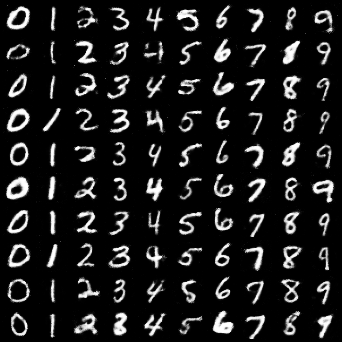

In [26]:
from IPython.display import Image, display
import os
import random

# Get a list of all image files in the "images/" directory
image_files = os.listdir("images/")

# Randomly choose one image file from the list
random_image_file = random.choice(image_files)

# Display the randomly selected image
img_path = os.path.join("images", random_image_file)
display(Image(filename=img_path))


In [27]:
# Number of Images generated during Training

print("Total number of generated images: ", len(image_files))


Total number of generated images:  470


In [28]:
import torch
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ms_ops
from mindspore import Parameter, load_checkpoint, load_param_into_net
from mindspore.train.serialization import load_checkpoint, load_param_into_net, save_checkpoint

save_path = "./Pytorch_Saved_Model"

# Load the parameters from PyTorch checkpoint files
generator_state_dict = torch.load(os.path.join(save_path, 'generator_model.pth'))
discriminator_state_dict = torch.load(os.path.join(save_path, 'discriminator_model.pth'))

name_mapping = {
    'label_emb.weight': 'label_emb.embedding_table',
    'model.0.dense.weight': 'block.0.weight',
    'model.0.dense.bias': 'block.0.bias',
    'model.0.batchnorm.weight': 'block.1.gamma',
    'model.0.batchnorm.bias': 'block.1.beta',
    'model.0.batchnorm.running_mean': 'block.1.moving_mean',
    'model.0.batchnorm.running_var': 'block.1.moving_variance',
    'model.1.dense.weight': 'block.2.weight',
    'model.1.dense.bias': 'block.2.bias',
    'model.1.batchnorm.weight': 'block.3.gamma',
    'model.1.batchnorm.bias': 'block.3.beta',
    'model.1.batchnorm.running_mean': 'block.3.moving_mean',
    'model.1.batchnorm.running_var': 'block.3.moving_variance',
    'model.2.dense.weight': 'block.4.weight',
    'model.2.dense.bias': 'block.4.bias',
    'model.3.dense.weight': 'block.5.weight',
    'model.3.dense.bias': 'block.5.bias',
    # Add more mappings as needed
}

# Convert and load the pytorch parameters into the MindSpore model
for name, param in generator.parameters_and_names():
    if name in name_mapping:
        param.set_data(generator_state_dict[name_mapping[name]].data.numpy())

for name, param in discriminator.parameters_and_names():
    if name in name_mapping:
        param.set_data(generator_state_dict[name_mapping[name]].data.numpy())

# Save the MindSpore models in the checkpoint format (.ckpt)
ms.save_checkpoint(generator, os.path.join(save_path, 'generator_model.ckpt'))
ms.save_checkpoint(discriminator, os.path.join(save_path, 'discriminator_model.ckpt'))

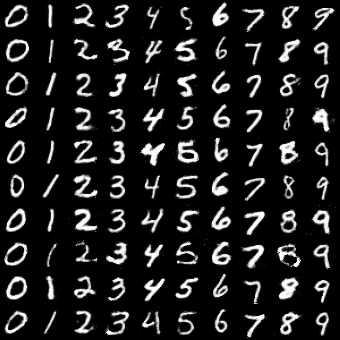

In [33]:
import os
import numpy as np
from PIL import Image
import mindspore as ms
from mindspore import Tensor, load_checkpoint, load_param_into_net

# Set the model to evaluation mode (important for dropout and batch normalization layers)
Generator().set_train(False)

# Generate a 10x10 grid of samples
grid_size = 10
batch_size = 64
noise_dim = 100
input_shape = (batch_size, noise_dim)
num_classes = 10  

# Set the model to evaluation mode (important for dropout and batch normalization layers)
generator.set_train(False)  
# Create a blank image to arrange the grid
grid_image = Image.new('L', (grid_size * 34, grid_size * 34))
# Generate a 10x10 grid of samples with labels from 0 to 9
for i in range(grid_size):
    for j in range(grid_size):
        # Generate random noise as input for the generator
        noise = np.random.normal(0, 1, size=input_shape).astype(np.float32)
        noise_tensor = ms.Tensor(noise, ms.float32)
        
        # Calculate the label based on the grid position
        label = j  # Transpose the row and column here
        labels = np.full((batch_size,), label, dtype=np.int32)
        labels_tensor = Tensor(labels, ms.int32)

        # Generate samples using the generator
        generated_samples = generator(noise_tensor, labels_tensor)

        # Assuming the generated_samples tensor has shape (batch_size, channels, height, width)
        # Reshape the tensor to (batch_size, height, width, channels)
        generated_samples = generated_samples.asnumpy().transpose(0, 2, 3, 1)

        # Convert tensor values from [-1, 1] to [0, 255] for image representation
        generated_samples = ((generated_samples + 1) * 127.5).astype(np.uint8)

        # Convert the generated image to PIL Image
        img = Image.fromarray(generated_samples[0][:, :, 0], mode='L')

        # Paste the image into the grid image with transposed row and column
        grid_image.paste(img, (j * 34, i * 34))  # Transpose the row and column here

# Display the transposed grid image
grid_image.show()


In [34]:
# Save the grid image with a unique name using a counter
generated_image_path = "./generated_image"
os.makedirs(generated_image_path, exist_ok=True)
# Convert the image to a NumPy array
grid_image_array = np.array(grid_image)

# Create or read the counter from a file
counter_file = os.path.join(generated_image_path, "counter.txt")
if os.path.exists(counter_file):
    with open(counter_file, 'r') as file:
        counter = int(file.read())
else:
    counter = 1

# Save the NumPy array as an image with a unique filename
file_name = f"image{counter}.png"
Image.fromarray(grid_image_array).save(os.path.join(generated_image_path, file_name))

# Increment the counter for the next image
counter += 1

# Save the updated counter back to the file
with open(counter_file, 'w') as file:
    file.write(str(counter))
